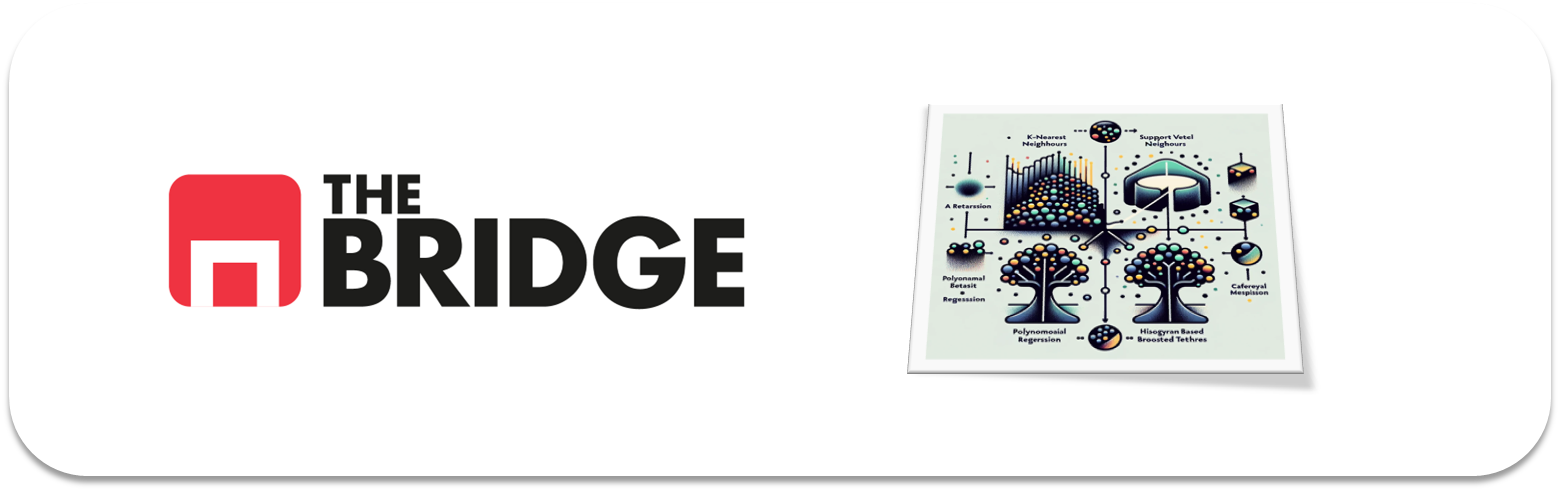

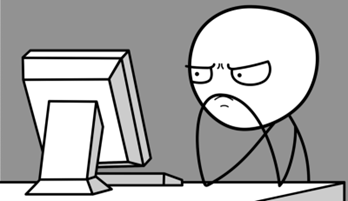

Para ejercitarte y afianzar lo aprendido sobre **Otros Modelos de aprendizaje supervisado**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import datascience as ds
import vizdatatools as viz

## PARTE 1. KNN

En la primera parte  vas a trabajar con una base de datos de reviews de una aplicación. Entre los datos podemos encontrar el texto de la review, las estrellas, así como el sentimiento del comentario (si es algo bueno o malo).

El objetivo es montar un algoritmo de clasificación que prediga el rating (ojo, no el sentimiento), en función del sentimiento del comentario y su valor y la cantidad de palabras empleadas en el mismo. Para ello tendrás que utilizar un algoritmo de tipo KNN.

### Ejercicio 1

Lee el archivo de entrada "reviews_sentiment.csv" y carga su contenido en un dataframe. Muestras sus primeras líneas, su información general y define una variable "target" asignándole el nombre de la columna que contenga el target del problema. 

In [3]:
df_sentiments = pd.read_csv(r'./data/reviews_sentiment.csv', sep=";")
df_sentiments.head()

,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,Hola desde hace algo más de un mes me pone sin...,23,negative,negative,1,-0.486389
1,faltan cosas,Han mejorado la apariencia pero no,20,negative,negative,1,-0.586187
2,Es muy buena lo recomiendo,Andres e puto amoooo,4,NaN,negative,1,-0.602240
3,Version antigua,Me gustana mas la version anterior esta es mas...,17,NaN,negative,1,-0.616271
4,Esta bien,Sin ser la biblia.... Esta bien,6,negative,negative,1,-0.651784


In [4]:
df_sentiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review Title    257 non-null    object 
 1   Review Text     257 non-null    object 
 2   wordcount       257 non-null    int64  
 3   titleSentiment  231 non-null    object 
 4   textSentiment   257 non-null    object 
 5   Star Rating     257 non-null    int64  
 6   sentimentValue  257 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 14.2+ KB


In [5]:
target = 'Star Rating' 

### Ejericicio 2

Muestra la distribución del target y coméntala brevemente.

In [8]:
df_sentiments[target].value_counts()

Star Rating
5    88
3    78
1    37
4    30
2    24
Name: count, dtype: int64

In [9]:
df_sentiments[target].value_counts(True)

Star Rating
5    0.342412
3    0.303502
1    0.143969
4    0.116732
2    0.093385
Name: proportion, dtype: float64

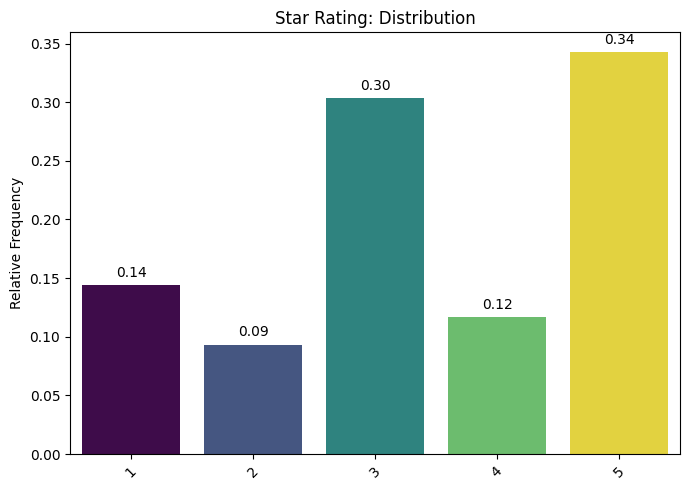

In [11]:
viz.plot_multiple_categorical_distributions(df_sentiments,
                                            [target],
                                            relative=True)

<Axes: xlabel='Star Rating', ylabel='count'>

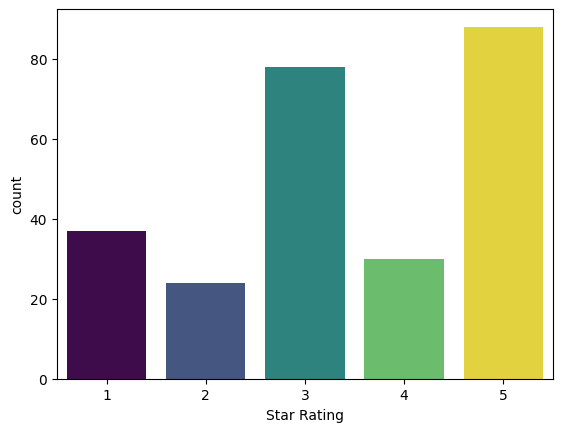

In [16]:
sns.countplot(df_sentiments, x=target, hue=target, palette='viridis', legend=False)

### Ejercicio 3

Deshazte de la columna "titleSentiment" que tiene nulos y no vamos a emplearla.

In [17]:
df_sentiments.drop(columns='titleSentiment', inplace=True)
df_sentiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review Title    257 non-null    object 
 1   Review Text     257 non-null    object 
 2   wordcount       257 non-null    int64  
 3   textSentiment   257 non-null    object 
 4   Star Rating     257 non-null    int64  
 5   sentimentValue  257 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 12.2+ KB


### Ejercicio 4

Haz el split en train y test.

In [19]:
train_set, test_set = train_test_split(df_sentiments, test_size=0.2, random_state=42)

### Ejercicio 5

Muestra la descripción de las variables que consideres numéricas (justificando tu elección) y sus histogramas. ¿Hay que aplicar alguna transformación o tratamiento? (Recuerda que vamos a emplear un KNN)

In [21]:
ds.get_cardinality(df_sentiments, 10, 30)

pandas.DataFrame shape:  (257, 6)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
Review Title,186,72.373541,0,0.0,object,Numeric - Continuous
Review Text,241,93.774319,0,0.0,object,Numeric - Continuous
wordcount,42,16.342412,0,0.0,int64,Numeric - Discrete
textSentiment,2,0.77821,0,0.0,object,Binary
Star Rating,5,1.945525,0,0.0,int64,Categoric
sentimentValue,241,93.774319,0,0.0,float64,Numeric - Continuous


Consideramos como realmente numéricas "wordcount", en cuyo caso no debes fijarte solo en su rango actual sino en el hecho de que las reviews pueden tener tantas palabras como quiera el que las escriba, y "sentimentValue", esta es claramente numérica continua.

In [33]:
features_num = ['wordcount', 'sentimentValue']

In [34]:
train_set[features_num].describe()

,wordcount,sentimentValue
count,205.000000,205.000000
mean,11.209756,0.400269
std,12.875341,0.871054
min,1.000000,-1.780889
25%,3.000000,-0.106498
50%,7.000000,0.244713
75%,15.000000,0.813521
max,103.000000,3.264579


array([[<Axes: title={'center': 'wordcount'}>,
        <Axes: title={'center': 'sentimentValue'}>]], dtype=object)

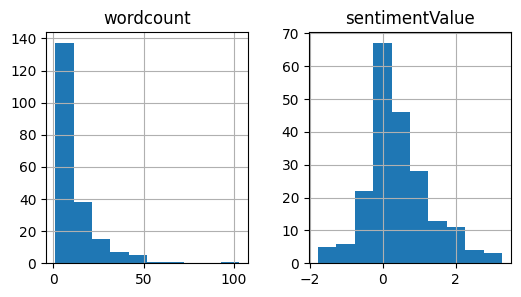

In [35]:
train_set[features_num].hist(figsize=(6, 3))

En ambos casos tendremos que escalar ya que los rangos son muy diversos y KNN es un algoritmo muy sensible a escalas ya que se basa en el cálculo de distancias entre instancias, considerando el conjunto de features como un vector. Además en el caso de `wordcount` una transformación, tipo logarítmica, no le vendría nada mal para "normalizarla" un poco.

### Ejercicio 6

Muestra la distribución frecuencial de las variables que consideres categóricas. ¿Habrías que hacerles algún tipo de tratamiento?

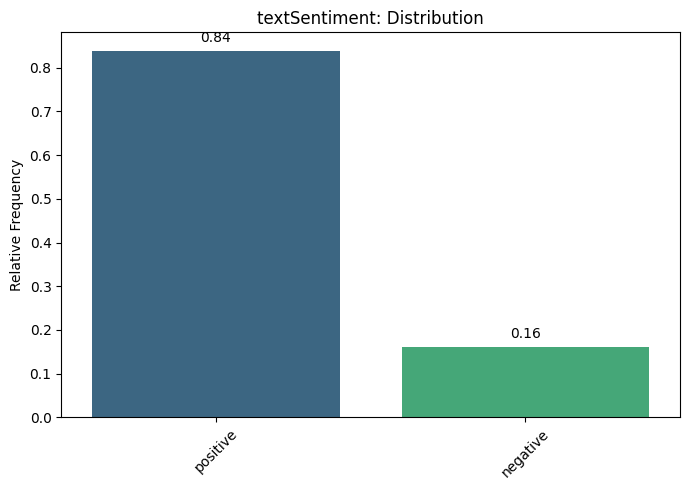

In [38]:
features_cat = ['textSentiment']

viz.plot_multiple_categorical_distributions(train_set, features_cat, relative=True)

Tendremos que convertirla a un valor numérico, como es binaria lo haremos a 0 y 1 (0 para negative, 1 para positive) aunque podríamos haber empleado un one-hot encoding, aquí si podemos suponer cierto "orden".

### Ejercicio 7

En un modelado completo habríamos comprobado la relación entre las features y el target, para estos ejercicios, las vamos a incluir sí o si. Haz el tratamiento de features, haciendo la conversión ordinal de la binaria (usa 1 para positive y 0 para negative) y aplicando el escalado que creas más conveniente en consecuencia para las numéricas

In [40]:
train_set['textSentiment'] = train_set['textSentiment'].apply(lambda row: 1 if row == "positive" else 0)
test_set['textSentiment'] = test_set['textSentiment'].apply(lambda row: 1 if row == "positive" else 0)

El escalado lo vamos a hacer con MaxMinScaler porque ya que hemos convertido la binaria en 0 y 1 el rango será similar. Ojo, en un KNN una conversión ordinal impacta bastante y después de hacerla puede ser posible que aún tuvieras que hacer un escalado a los valores obtenidos.

In [41]:
minmax_scaler = MinMaxScaler()
train_set[features_num] = minmax_scaler.fit_transform(train_set[features_num])
test_set[features_num] = minmax_scaler.transform(test_set[features_num])
 

> El minmax no necesita la transformación previa logarítmica o cuadrática o cúbica, porque no presupone normalidad de la distribución de los datos.

In [42]:
train_set.describe()

,wordcount,textSentiment,Star Rating,sentimentValue
count,205.000000,205.000000,205.000000,205.000000
mean,0.100096,0.839024,3.414634,0.432301
std,0.126229,0.368408,1.389308,0.172641
min,0.000000,0.000000,1.000000,0.000000
25%,0.019608,1.000000,3.000000,0.331860
50%,0.058824,1.000000,3.000000,0.401470
75%,0.137255,1.000000,5.000000,0.514206
max,1.000000,1.000000,5.000000,1.000000


In [43]:
test_set.describe()

,wordcount,textSentiment,Star Rating,sentimentValue
count,52.000000,52.000000,52.000000,52.000000
mean,0.114253,0.750000,3.442308,0.416217
std,0.140201,0.437237,1.500503,0.198932
min,0.000000,0.000000,1.000000,-0.098223
25%,0.019608,0.750000,3.000000,0.301665
50%,0.073529,1.000000,3.500000,0.417492
75%,0.151961,1.000000,5.000000,0.493691
max,0.735294,1.000000,5.000000,0.932576


### Ejercicio 8

Crea el juego X,y de train y test. Carga el modelo, instancialo con un k=5 para empezar y entrénalo.

In [44]:
X_train = train_set[features_cat + features_num]
y_train = train_set[target]
X_test = test_set[features_cat + features_num]
y_test = test_set[target]

In [46]:
n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier()

### Ejercicio 9

Evalúalo contra el propio train y contra test, ¿qué puedes decir de los resultados?

In [48]:
# Análisis contra train
print(classification_report(y_train, knn.predict(X_train)))

              precision    recall  f1-score   support

           1       0.93      0.96      0.95        27
           2       0.95      0.86      0.90        22
           3       0.88      0.94      0.91        64
           4       0.94      0.74      0.83        23
           5       0.94      0.97      0.96        69

    accuracy                           0.92       205
   macro avg       0.93      0.89      0.91       205
weighted avg       0.92      0.92      0.92       205



In [49]:
# Análisis contra test
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           1       0.82      0.90      0.86        10
           2       0.50      1.00      0.67         2
           3       0.86      0.86      0.86        14
           4       1.00      0.43      0.60         7
           5       0.90      0.95      0.92        19

    accuracy                           0.85        52
   macro avg       0.82      0.83      0.78        52
weighted avg       0.87      0.85      0.84        52



> Es un modelo que en general parece generalizar relativamente bien, salvo quizá respecto al rating 4, donde la alta precisión penaliza el recall y el rating 2, donde la baja precision ayuda al recall. En terminos de recall medio parece bastante interesante, pero sería bueno ver cómo le sentaría aplicar alguna de las técnicas de balanceado. Eso sí, al tiempo que probamos otros valores de k.

### Ejercicio 10

Vamos a "ajustar a mano" el valor de K, probando diferentes valores entre 1 y 20. Para ello haz un bucle que cambie el valor de K y obtenga mediante validación cruzada el valor del "balanced accuracy" para cada "modelo" y se quede con el k que mejor métrica obtenga. Luego entrena un modelo para ese k y evalúalo contra el target.

In [51]:
def find_best_k(X_train, y_train, k_range=20):
    """
    Find the optimal number of neighbors (k) for a KNeighborsClassifier using cross-validation
    based on the "balanced accuracy" metric.

    Parameters
    ----------
    X_train: array-like of shape (n_samples, n_features)
        Training data.
    y_train: array-like of shape (n_samples,)
        Target values.
    k_range: int, optional, default=20
        The maximum number of neighbors to try.

    Returns
    -------
    best_k: int
        The value of k that gives the best balanced accuracy.
    best_model: KNeighborsClassifier object
        The trained KNeighborsClassifier with the optimal k.
    best_score: float
        The best balanced accuracy score achieved during cross-validation.
    """
    metrics = []
    for k in range(1, k_range + 1):
        print(f"Evaluating for k = {k}, balanced accuracy =", end=" ")
        model = KNeighborsClassifier(n_neighbors=k)
        balanced_accuracy = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="balanced_accuracy"))
        metrics.append(balanced_accuracy)
        print(balanced_accuracy)
    
    # Identify the best k
    best_k = np.argmax(metrics) + 1  # Add 1 because np.argmax returns the index (0-based)
    best_score = metrics[best_k - 1]
    print(f"Best k = {best_k}, with balanced accuracy = {best_score}")
    
    # Train the final model with the best k
    best_model = KNeighborsClassifier(n_neighbors=best_k)
    best_model.fit(X_train, y_train)
    
    return best_k, best_model, best_score



In [53]:
best_k, best_model, best_score = find_best_k(X_train, y_train, 20)
best_model.fit(X_train, y_train)


Evaluating for k = 1, balanced accuracy = 0.8507179487179487
Evaluating for k = 2, balanced accuracy = 0.8575824175824176
Evaluating for k = 3, balanced accuracy = 0.8667765567765567
Evaluating for k = 4, balanced accuracy = 0.8561758241758242
Evaluating for k = 5, balanced accuracy = 0.8522637362637362
Evaluating for k = 6, balanced accuracy = 0.8291868131868132
Evaluating for k = 7, balanced accuracy = 0.8422637362637364
Evaluating for k = 8, balanced accuracy = 0.8242637362637362
Evaluating for k = 9, balanced accuracy = 0.7974065934065935
Evaluating for k = 10, balanced accuracy = 0.8002637362637361
Evaluating for k = 11, balanced accuracy = 0.793120879120879
Evaluating for k = 12, balanced accuracy = 0.7822637362637362
Evaluating for k = 13, balanced accuracy = 0.7822637362637362
Evaluating for k = 14, balanced accuracy = 0.7853406593406594
Evaluating for k = 15, balanced accuracy = 0.7724835164835164
Evaluating for k = 16, balanced accuracy = 0.7542637362637363
Evaluating for k =

KNeighborsClassifier(n_neighbors=3)

In [54]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.80      0.80      0.80        10
           2       0.40      1.00      0.57         2
           3       1.00      0.86      0.92        14
           4       1.00      0.43      0.60         7
           5       0.86      1.00      0.93        19

    accuracy                           0.85        52
   macro avg       0.81      0.82      0.76        52
weighted avg       0.89      0.85      0.84        52



> Un punto interesenta para comentar es el que puede observar comparando estos resultados contra los de test del modelo entrenado con k=5. ¿No deberíamos quedarnos con k=5? No, el set de test es un examen para hacernos a la idea de cómo puede generalizar nuestro modelo y como se comportará ante datos nuevos pero claro es sólo un set de los muchísimos posibles que podremos encontrarnos en el futuro, es por lo que comparar modelos entre sí por su puntuación en el set de test es menos fiable que compararlos usando la validación cruzada donde en realidad se hace una media de tantas pruebas o tantos "test" como k-folds hayamos definido en el parámetro cv. La evaluación contra test del modelo definitivo sirve para "gestionar" nuestras expectativas del comportamiento futuro.

### Ejercicio 11

Repasa la ficha de KNN o la documentación de sklearn y, usando un grid y una estrategia completa (GridSearch), busca la mejor combinación de k y weights que puedas, empleando de nuevo "balanced_accuracy" como métrica.

In [56]:
param_grid = {
    "n_neighbors": range(1,20),
    "weights": ["uniform", "distance"]
}

knn_grid = GridSearchCV(knn, 
                        param_grid=param_grid,
                        cv=5,
                        scoring="balanced_accuracy")

knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 20),
                         'weights': ['uniform', 'distance']},
             scoring='balanced_accuracy')

In [57]:
knn_grid.best_params_

{'n_neighbors': 3, 'weights': 'uniform'}

In [58]:
knn_grid.best_score_

0.8667765567765567

In [59]:
print(classification_report(y_test, knn_grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           1       0.80      0.80      0.80        10
           2       0.40      1.00      0.57         2
           3       1.00      0.86      0.92        14
           4       1.00      0.43      0.60         7
           5       0.86      1.00      0.93        19

    accuracy                           0.85        52
   macro avg       0.81      0.82      0.76        52
weighted avg       0.89      0.85      0.84        52

